In [ ]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from sentence_transformers import CrossEncoder
from sentence_transformers import SentenceTransformer
from tensorflow.keras.losses import CosineSimilarity
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, accuracy_score
from scipy.stats import spearmanr
from scipy.optimize import minimize
import random
from torch.utils.data import DataLoader
import math
from sentence_transformers import LoggingHandler, util
from sentence_transformers.cross_encoder.evaluation import CECorrelationEvaluator
from sentence_transformers import InputExample
import logging
from datetime import datetime
import sys
import os
import gzip
import csv

In [ ]:
fa = open("data/trial-v1.json")
test_data = json.load(fa)

fb = open("data/val.model-agnostic.json")
valag = json.load(fb)

fc = open("data/train.model-agnostic.json")
trainag = json.load(fc)

#fd = open("data/train.model-aware.json")
#trainaw = json.load(fd)

fe = open("data/val.model-aware.v2.json")
valaw = json.load(fe)


In [ ]:
train_data = trainag

In [ ]:
val_data = valag + valaw

In [ ]:
combined = test_data + val_data
N = len(combined)

In [ ]:
hyps = [d["hyp"] for d in combined[:N]]
short_tgt_entries = [entry for entry in combined[:N] if len(entry['tgt']) < 5]
tgts = []
for d in combined[:N]:
  if d in short_tgt_entries:
    tgts.append(d["src"])
  else:
    tgts.append(d["tgt"])

labels = np.array([1-d["p(Hallucination)"] for d in combined[:N]])

In [ ]:
def max_accuracy(pred, labels):
    sol = minimize(lambda t: -accuracy_score((pred>t).astype(int), (labels > 0.5).astype(int)), x0=0.5, method='nelder-mead')
    return (-sol.fun, sol.x[0])

#cosine sim

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
hyps_enc = model.encode(hyps)
tgts_enc = model.encode(tgts)

In [ ]:
cosine = CosineSimilarity(reduction="none")
def cosine_sim(hyps_enc = hyps_enc, tgts_enc = tgts_enc, labels = labels, threshold = 0.5):
    pred = 1-np.diag(cosine_similarity(hyps_enc, tgts_enc))
    return {
        "mse": mean_squared_error(pred, labels),
        "acc": accuracy_score((pred>threshold).astype(int), (labels > 0.5).astype(int)),
        "spearman": spearmanr(pred, labels).statistic,
        "max_acc": max_accuracy(pred, labels)
    }

Below we have the cosine similarity performance with hyp and tgt

In [ ]:
cosine_sim()

{'mse': 0.30914111586880416,
 'acc': 0.31203703703703706,
 'spearman': -0.540173481170249,
 'max_acc': (0.43148148148148147, 1.0750000000000013)}

#paraphrase



In [ ]:
combined

[{'hyp': 'A district of Kowloon, China.',
  'ref': 'tgt',
  'src': "The City <define> Chiuchow </define> is Kowloon 's other top restaurant and is famous for its goose dishes and other specialties from the Chiuchow region ( you may also wish to try the beef satay done in a creamy sauce ) .",
  'tgt': 'The Chaoshan region where the Teochew dialect is spoken.',
  'model': '',
  'task': 'DM',
  'labels': ['Hallucination', 'Hallucination', 'Hallucination'],
  'label': 'Hallucination',
  'p(Hallucination)': 1.0},
 {'hyp': '(Wicca) A witchdoctor.',
  'ref': 'tgt',
  'src': '“ I went to see the witchdoctor , the <define> igqira </define> . And he spoke to the izinyanya , the spirits of the ancestors . ”',
  'tgt': '(South Africa) A traditional tribal diviner or spiritual healer.',
  'model': '',
  'task': 'DM',
  'labels': ['Hallucination', 'Hallucination', 'Not Hallucination'],
  'label': 'Hallucination',
  'p(Hallucination)': 0.6666666666666666},
 {'hyp': '(nautical) A halyard.',
  'ref': '

In [ ]:
def extract(data, task):
  final = []
  for i in range(len(data)):
    if data[i]["task"] == task:
      final.append(data[i])
    else:
      continue
  return final

In [ ]:
pg = extract(combined, 'PG')
mt = extract(combined, 'MT')
dm = extract(combined, 'DM')

In [ ]:
def labeler(combined):
  hyps = [d["hyp"] for d in combined[:N]]
  short_tgt_entries = [entry for entry in combined[:N] if len(entry['tgt']) < 5]
  tgts = []
  for d in combined[:N]:
    if d in short_tgt_entries:
      tgts.append(d["src"])
    else:
      tgts.append(d["tgt"])

  labels = np.array([1-d["p(Hallucination)"] for d in combined[:N]])
  return (hyps, tgts, labels)

In [ ]:
pg_te = labeler(pg)
dm_te = labeler(dm)
mt_te = labeler(mt)

In [ ]:
sentences_pg = [(tgt,hyp) for tgt, hyp in zip(pg_te[0], pg_te[1])]
sentences_mt = [(tgt,hyp) for tgt, hyp in zip(mt_te[0], mt_te[1])]
sentences_dm = [(tgt,hyp) for tgt, hyp in zip(dm_te[0], dm_te[1])]

In [ ]:
labels_pg = pg_te[2]
labels_mt = mt_te[2]
labels_dm = dm_te[2]

#cross encoder test


In [ ]:
sentences = [(tgt,hyp) for tgt, hyp in zip(tgts, hyps)]

In [ ]:
model = CrossEncoder('cross-encoder/stsb-roberta-large')

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/139 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
def cross_encoder(model, sentences = sentences, labels = labels, threshold = 0.5):
    pred = model.predict(sentences)
    return {
        "mse": mean_squared_error(pred, labels),
        "acc": accuracy_score((pred>threshold).astype(int), (labels > 0.5).astype(int)),
        "spearman": spearmanr(pred, labels).statistic,
        "max_acc": max_accuracy(pred, labels)
    }

In [ ]:
cross_encoder(model, sentences_pg, labels_pg)

{'mse': 0.07766532543594602,
 'acc': 0.7644787644787645,
 'spearman': 0.4885076367036571,
 'max_acc': (0.7683397683397684, 0.525)}

In [ ]:
cross_encoder(model,sentences_mt, labels_mt)

{'mse': 0.09138854570433415,
 'acc': 0.7317073170731707,
 'spearman': 0.7641790865361489,
 'max_acc': (0.8170731707317073, 0.7640625000000008)}

In [ ]:
cross_encoder(model,sentences_dm, labels_dm)

{'mse': 0.0697288225326818,
 'acc': 0.7518248175182481,
 'spearman': 0.6990597094403248,
 'max_acc': (0.7688564476885644, 0.53125)}

In [ ]:
cross_encoder(model,sentences, labels)

{'mse': 0.08169967270364008,
 'acc': 0.7481481481481481,
 'spearman': 0.6781231058330586,
 'max_acc': (0.7666666666666667, 0.5750000000000002)}

#Training


In [ ]:
N = len(train_data)

In [ ]:
pg1 = extract(train_data, 'PG')
mt1 = extract(train_data, 'MT')
dm1 = extract(train_data, 'DM')

In [ ]:
def labelertr(combined):
  hyps = [d["hyp"] for d in combined[:N]]
  short_tgt_entries = [entry for entry in combined[:N] if len(entry['tgt']) < 5]
  tgts = []
  for d in combined[:N]:
    if d in short_tgt_entries:
      tgts.append(d["src"])
    else:
      tgts.append(d["tgt"])
  return (hyps, tgts)

In [ ]:
pg_tr = labelertr(pg1)
dm_tr = labelertr(dm1)
mt_tr = labelertr(mt1)

In [ ]:
sentences_pg1 = [(tgt,hyp) for tgt, hyp in zip(pg_tr[0], pg_tr[1])]
sentences_mt1 = [(tgt,hyp) for tgt, hyp in zip(mt_tr[0], mt_tr[1])]
sentences_dm1 = [(tgt,hyp) for tgt, hyp in zip(dm_tr[0], dm_tr[1])]

In [ ]:
len(sentences_pg1)

10000

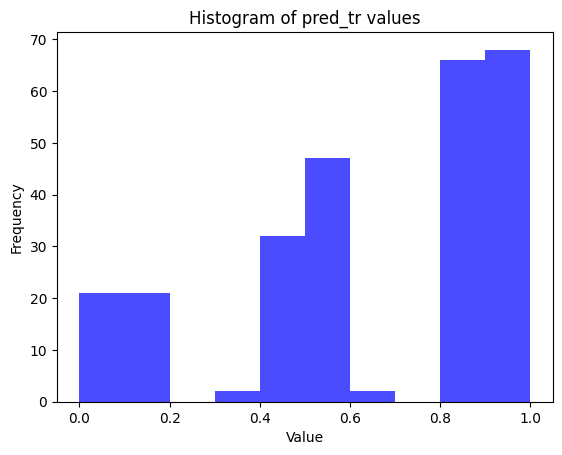

In [ ]:
plt.hist(labels_pg, bins=10, alpha=0.7, color='blue')
plt.title('Histogram of pred_tr values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

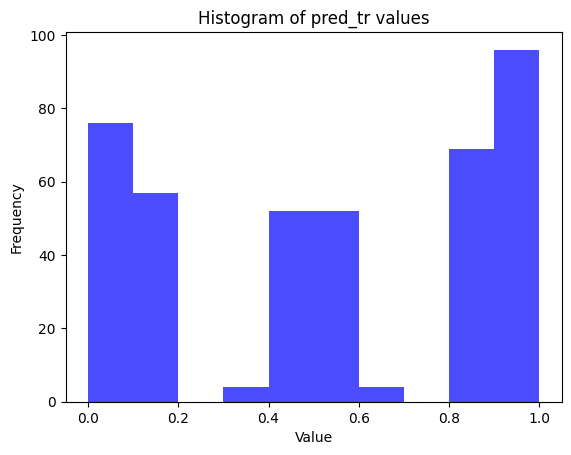

In [ ]:
plt.hist(labels_mt, bins=10, alpha=0.7, color='blue')
plt.title('Histogram of pred_tr values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

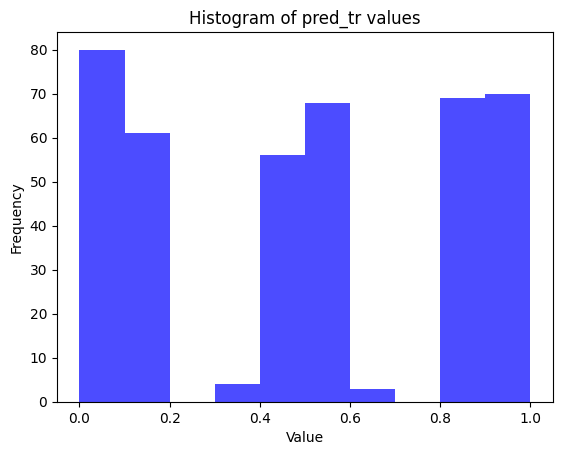

In [ ]:
plt.hist(labels_dm, bins=10, alpha=0.7, color='blue')
plt.title('Histogram of pred_tr values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
model = CrossEncoder('cross-encoder/stsb-roberta-large')

In [ ]:
def predicto(sentences):
  pred_tr = (model.predict(sentences))
  plt.hist(pred_tr, bins=1000, alpha=0.7, color='blue')
  plt.title('Histogram of pred_tr values')
  plt.xlabel('Value')
  plt.ylabel('Frequency')
  plt.show()
  return pred_tr

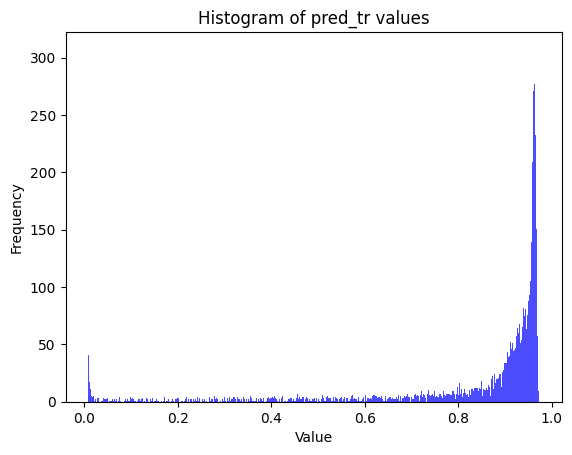

In [ ]:
pred_pg = predicto(sentences_pg1)

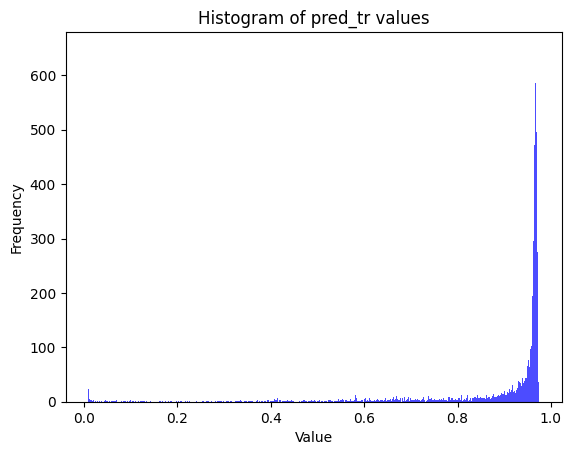

In [ ]:
pred_mt = predicto(sentences_mt1)

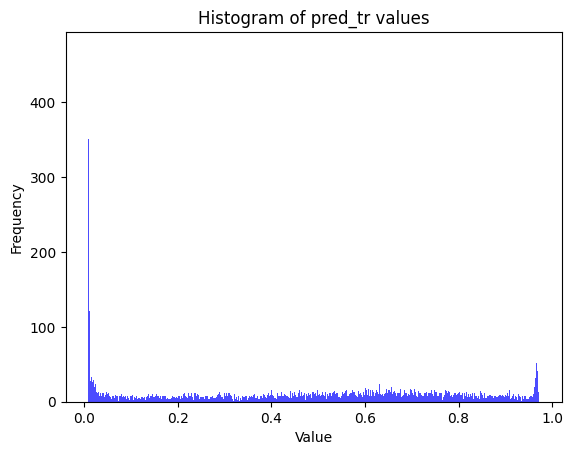

In [ ]:
pred_dm = predicto(sentences_dm1)

In [ ]:
labeled_pg1 = [{'texts': sentences_pg1[ind], 'label': pred_pg[ind]} for ind in range(len(pred_pg))]
labeled_mt1 = [{'texts': sentences_mt1[ind], 'label': pred_mt[ind]} for ind in range(len(pred_mt))]
labeled_dm1 = [{'texts': sentences_dm1[ind], 'label': pred_dm[ind]} for ind in range(len(pred_dm))]

In [ ]:
tr_pg = labeled_pg1.copy()
tr_mt = labeled_mt1.copy()
tr_dm = labeled_dm1.copy()

In [ ]:
n = len(tr_pg)

In [ ]:
pg_tr = tr_pg[:int(n*0.9)]
pg_dev = tr_pg[int(n*0.9):]
mt_tr = tr_mt[:int(n*0.9)]
mt_dev = tr_mt[int(n*0.9):]
dm_tr = tr_dm[:int(n*0.9)]
dm_dev = tr_dm[int(n*0.9):]

In [ ]:
train_samples_pg = [InputExample(texts= item["texts"], label=item["label"]) for item in pg_tr]
dev_samples_pg = [InputExample(texts= item["texts"], label=item["label"]) for item in pg_dev]
test_samples_pg = [InputExample(texts = sentence, label = label) for sentence, label in zip(sentences_pg,labels_pg)]

In [ ]:
modello = CrossEncoder('cross-encoder/stsb-roberta-large')
cross_encoder(modello, sentences_pg, labels_pg)

{'mse': 0.07766532543594602,
 'acc': 0.7644787644787645,
 'spearman': 0.4885076367036571,
 'max_acc': (0.7683397683397684, 0.525)}

In [ ]:
#Define our Cross-Encoder
train_batch_size = 8

num_epochs = 1
model_save_path_pg = 'training-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")


#### Just some code to print debug information to stdout
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])
logger = logging.getLogger(__name__)
#### /print debug information to stdout

#We use distilroberta-base as base model and set num_labels=1, which predicts a continous score between 0 and 1
model = CrossEncoder('cross-encoder/stsb-roberta-large', num_labels = 1)

# We wrap train_samples (which is a List[InputExample]) into a pytorch DataLoader
train_dataloader = DataLoader(train_samples_pg, shuffle=True, batch_size=train_batch_size)

#MIRROR TRAINING EXAMPLES


# We add an evaluator, which evaluates the performance during training
evaluator = CECorrelationEvaluator.from_input_examples(dev_samples_pg, name='hal-dev')


# Configure the training
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
logger.info("Warmup-steps: {}".format(warmup_steps))


# Train the model
model.fit(train_dataloader=train_dataloader,
          evaluator=evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          output_path=model_save_path_pg)


##### Load model and eval on test set
model = CrossEncoder(model_save_path_pg)

evaluator = CECorrelationEvaluator.from_input_examples(test_samples_pg, name='sts-test')
evaluator(model)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1125 [00:00<?, ?it/s]

0.4419313921562026

In [ ]:
cross_encoder(model, sentences_pg, labels_pg)

{'mse': 0.08783010331049161,
 'acc': 0.7606177606177607,
 'spearman': 0.44193139215620253,
 'max_acc': (0.7606177606177607, 0.5)}

In [ ]:
train_samples_mt = [InputExample(texts= item["texts"], label=item["label"]) for item in mt_tr]
dev_samples_mt = [InputExample(texts= item["texts"], label=item["label"]) for item in mt_dev]
test_samples_mt = [InputExample(texts = sentence, label = label) for sentence, label in zip(sentences_mt,labels_mt)]

In [ ]:
modello = CrossEncoder('cross-encoder/stsb-roberta-large')
cross_encoder(modello, sentences_mt, labels_mt)

{'mse': 0.09138854570433415,
 'acc': 0.7317073170731707,
 'spearman': 0.7641790865361489,
 'max_acc': (0.8170731707317073, 0.7640625000000008)}

In [ ]:
#Define our Cross-Encoder
train_batch_size = 8

num_epochs = 1
model_save_path_mt = 'training-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")


#### Just some code to print debug information to stdout
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])
logger = logging.getLogger(__name__)
#### /print debug information to stdout

#We use distilroberta-base as base model and set num_labels=1, which predicts a continous score between 0 and 1
model = CrossEncoder('cross-encoder/stsb-roberta-large', num_labels = 1)

# We wrap train_samples (which is a List[InputExample]) into a pytorch DataLoader
train_dataloader = DataLoader(train_samples_mt, shuffle=True, batch_size=train_batch_size)

#MIRROR TRAINING EXAMPLES


# We add an evaluator, which evaluates the performance during training
evaluator = CECorrelationEvaluator.from_input_examples(dev_samples_mt, name='hal-dev')


# Configure the training
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
logger.info("Warmup-steps: {}".format(warmup_steps))


# Train the model
model.fit(train_dataloader=train_dataloader,
          evaluator=evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          output_path=model_save_path_mt)


##### Load model and eval on test set
model = CrossEncoder(model_save_path_mt)

evaluator = CECorrelationEvaluator.from_input_examples(test_samples_mt, name='sts-test')
evaluator(model)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1125 [00:00<?, ?it/s]

0.7561545806443966

In [ ]:
cross_encoder(model, sentences_mt, labels_mt)

{'mse': 0.1100970974047119,
 'acc': 0.6853658536585366,
 'spearman': 0.7561545806443966,
 'max_acc': (0.8048780487804879, 0.8242187500000009)}

In [ ]:
train_samples_dm = [InputExample(texts= item["texts"], label=item["label"]) for item in dm_tr]
dev_samples_dm = [InputExample(texts= item["texts"], label=item["label"]) for item in dm_dev]
test_samples_dm = [InputExample(texts = sentence, label = label) for sentence, label in zip(sentences_dm,labels_dm)]

In [ ]:
modello = CrossEncoder('cross-encoder/stsb-roberta-large')
cross_encoder(modello, sentences_dm, labels_dm)

In [ ]:
#Define our Cross-Encoder
train_batch_size = 8

num_epochs = 1
model_save_path_dm = 'training-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")


#### Just some code to print debug information to stdout
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])
logger = logging.getLogger(__name__)
#### /print debug information to stdout

#We use distilroberta-base as base model and set num_labels=1, which predicts a continous score between 0 and 1
model = CrossEncoder('cross-encoder/stsb-roberta-large', num_labels = 1)

# We wrap train_samples (which is a List[InputExample]) into a pytorch DataLoader
train_dataloader = DataLoader(train_samples_dm, shuffle=True, batch_size=train_batch_size)

#MIRROR TRAINING EXAMPLES


# We add an evaluator, which evaluates the performance during training
evaluator = CECorrelationEvaluator.from_input_examples(dev_samples_dm, name='hal-dev')


# Configure the training
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
logger.info("Warmup-steps: {}".format(warmup_steps))


# Train the model
model.fit(train_dataloader=train_dataloader,
          evaluator=evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          output_path=model_save_path_dm)


##### Load model and eval on test set
model = CrossEncoder(model_save_path_dm)

evaluator = CECorrelationEvaluator.from_input_examples(test_samples_dm, name='sts-test')
evaluator(model)

In [ ]:
cross_encoder(model, sentences_dm, labels_dm)

In [ ]:
evaluator = CECorrelationEvaluator.from_input_examples(test_samples, name='sts-test')
modello = CrossEncoder('cross-encoder/stsb-roberta-large')
evaluator(modello)

In [ ]:
model = CrossEncoder(model_save_path)

In [ ]:
cross_encoder(sentences, labels)

{'mse': 0.08674911423289991,
 'acc': 0.7425925925925926,
 'spearman': 0.6853481703496629,
 'max_acc': (0.7805555555555556, 0.6625000000000003)}